# Build and train VGG16

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as K
print(f"tf: {tf.__version__}")

tf: 2.4.1


In [3]:
from datetime import datetime
import pydicom

In [4]:
start_time = datetime.now()

# Part 1. Use a custom image data generator which takes in DICOM images.

### Load the CSV file you saved in Part 1 in a pandas DataFrame

In [5]:
# Import the larger file so I can later stratify on where the images came from if I want to
df = pd.read_csv('../data/ct_dataset_full.csv')
df.head(3)

,file,has_covid,dcm_file
0,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_0.dcm
1,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_1.dcm
2,../data/COVID-CT-master/Images-processed/CT_CO...,1,../data/dicom_ct/covid/covidchest_2.dcm


In [6]:
# sanity checks
print(f"total files: {df.shape[0]}")
print(f"total covid: {df['has_covid'].sum()}")
print(f"overall fraction covid: {df['has_covid'].sum()/df.shape[0]:.2}")

total files: 746
total covid: 349
overall fraction covid: 0.47


### Split n the DataFrame into train, test DataFrame using the function train_test_split(test_size=0.2) from the sklearn.model_selection library

In [7]:
# This is how I've used train_test_split in the past
if (0):

    X = df['dcm_file']
    y = df['has_covid']
    X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.2, random_state=42)

    print(X_train[:2],y_train[:2])

    # sanity checks
    print(f"TRAIN:  {len(X_train)}  fraction covid: {sum(y_train)/len(y_train):.2}")
    print(f"VALID:   {len(X_valid)}  fraction covid: {sum(y_valid)/len(y_valid):.2}")
    print(f"TEST:    {len(X_test)}  fraction covid: {sum(y_test)/len(y_test):.2}")

In [8]:
# Learning a few new tricks..


df['has_covid'] = df['has_covid'].apply(str) # trying to fix the TypeError occuring later

# Only pass the columns I need to the split

train_df, test_df = train_test_split(df[['dcm_file','has_covid']], test_size=0.2, random_state=42)

In [9]:
print(train_df.shape, test_df.shape)

(596, 2) (150, 2)


In [10]:
train_df.head(3)

,dcm_file,has_covid
70,../data/dicom_ct/covid/covidchest_70.dcm,1
164,../data/dicom_ct/covid/covidchest_164.dcm,1
710,../data/dicom_ct/no_covid/nocovidchest_361.dcm,0


### Add train/ test/ validation data augmentation parameters in a dictionary form or use the Keras preprocessing function.

This workflow is not my usual, but I'm going to try it out. Starting with a copy from the hint.

In [11]:
# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 32
CLASS_MODE = 'binary'
COLOR_MODE = 'grayscale'
TARGET_SIZE = (300, 300)
EPOCHS = 10
SEED = 1337

# from solutions...not sure why the change when we have the same input data...ResNet requires 3 channels?
BATCH_SIZE = 16
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 100
#SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}


### Set training/ test/ validation parameters such as BATCH_SIZE, CLASS_MODE, COLOR_MODE, TARGET_SIZE, and EPOCHS.

In [12]:
# most training parameters were set above
use_epochs = 5  # 5 for sanity check, 5000 for actual run

checkpoint_model_full = 'model_best_resnet50_CT.h5'

### Create a data generator class for reading in DICOM images or use the class provided. With this custom datagenerator class create a train and validation generator.

I've used several methods to ingest data, but not a custom class. I'm opting to use, dissect, and possibly transform the class provided.

In [13]:
#from tensorflow.keras import DataFrameIterator
#from tensorflow.keras.keras_preprocessing import DataFrameIterator
#from tensorflow.keras.preprocessing.image import DataFrameIterator
#from keras.preprocessing.image import DataFrameIterator

# None of these worked, but I do see the class listed in the docs at
# https://keras.io/api/preprocessing/image/ right under flow_from_dataframe

In [14]:
#tf.keras.preprocessing.image.ImageDataGenerator # yes, this works

In [15]:
#tf.keras.preprocessing.image.DataFrameIterator # no

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

In [17]:
# From DCMDataFrameIterator.py
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]

        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str
        # mod because of error
        #batch_y = np.array(self.y.iloc[indices_array]) # .astype(str) does not solve the problem
        
        
        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array


In [18]:
# # can't seem to get rid of error
# # TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.
# # try converting the column
# # TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.
# train_df['has_covid'] = train_df['has_covid'].apply(str)
# test_df['has_covid'] = test_df['has_covid'].astype(str)

# # but this triggers the message about setting value on a slice from a DataFrame

In [19]:
# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)


train_generator = DCMDataFrameIterator(
        dataframe=train_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=train_augmenter,
        **train_consts)

valid_generator = DCMDataFrameIterator(
        dataframe=train_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=valid_augmenter,
        **valid_consts)

Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


In [20]:
# TypeError: If class_mode="binary", y_col="has_covid" column values must be strings.

# Part 2. Build a ResNet50 model from scratch and train using X-ray images

### Build the ResNet50 model from scratch using correct layers and activations.

In [21]:
num_categories = 2

In [22]:
print(TARGET_SIZE)

(224, 224)


### Use the Sequential API method and just build VGG16

In [23]:
if (0):
    model = K.models.Sequential(name='vgg16')

    model.add(K.layers.Conv2D(input_shape=(300,300,1),
                     filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(K.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(K.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(K.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(K.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(K.layers.Flatten())

    model.add(K.layers.Dense(units=4096,activation="relu"))
    model.add(K.layers.Dense(units=4096,activation="relu"))

    # multi-class task
    #model.add(K.layers.Dense(units=num_categories, activation="softmax")) # units needs to be the same as the num classes
    # binary task
    model.add(K.layers.Dense(1, activation="sigmoid"))


### Come back and try it a new way

In [24]:
# Stem
# Learner
# Task
#x = vgg_learner(vgg_learner[ []])

### Build ResNet50 from my wk2_1.2 notebook

In [25]:
# from tensorflow.keras import Model
import tensorflow.keras.layers as layers

In [26]:
# v2 introduced the concept of pre-activation batch normalization (BN-RE-Conv)
#def identity_block(x, n_filters):  # JS change
def identity_block(n_filters, x, axis=3):
    """ Create a Bottleneck Residual Block of Convolutions
        n_filters: number of filters
        x        : input into the block
    """
    
    # after a `Conv2D` layer with `data_format="channels_first"`, set `axis=1` in `BatchNormalization`
    shortcut = x
 
    # dimensionality reduction
    x = layers.BatchNormalization(axis=axis)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, (1, 1), strides=(1, 1))(x)
         # bottleneck layer
    x = layers.BatchNormalization(axis=axis)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same")(x)
 
    # dimensionality restoration
    x = layers.BatchNormalization(axis=axis)(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters * 4, (1, 1), strides=(1, 1))(x)
 
    x = layers.add([shortcut, x])
    return x

In [27]:
# V1.5
#def projection_block(x, n_filters, strides=(2,2)): # JS change
def projection_block(n_filters, x, strides=(2,2), axis=3):
    """ Create Block of Convolutions with feature pooling
        Increase the number of filters by 4X
        x        : input into the block
        n_filters: number of filters
    """
    # construct the identity link
    # increase filters by 4X to match shape when added to output of block
    # JS -- or maybe not? Try 2*
    js_mult = 4 # 4 was original
    shortcut = layers.Conv2D(js_mult * n_filters, (1, 1), strides=strides)(x) # AF
    shortcut = layers.BatchNormalization(axis=axis)(shortcut)
    
    # construct the 1x1, 3x3, 1x1 convolution block
    # dimensionality reduction
    x = layers.Conv2D(n_filters, (1, 1), strides=strides)(x) # JS instructor has 2,2
    #x = layers.Conv2D(n_filters, (1, 1), strides=(2, 2))(x) # AF
    x = layers.BatchNormalization(axis=axis)(x)
    x = layers.ReLU()(x)
    # bottleneck layer
    # feature pooling when strides=(2, 2)
    #x = layers.Conv2D(n_filters, (3, 3), strides=(2, 2), padding='same')(x) # AF
    x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x) # TDS
    x = layers.BatchNormalization(axis=axis)(x)
    x = layers.ReLU()(x)
    # dimensionality restoration
    # increase the number of filters by 4X
    x = layers.Conv2D(4 * n_filters, (1, 1), strides=(1, 1))(x) # AF
    x = layers.BatchNormalization(axis=axis)(x)
    
    # add the  identity link to the output of the convolution block
    # getting an error: with shapes (14, 14, 256) (56, 56, 256)
    # changing js_mult to 2 changes this to shapes (28, 28, 256) (56, 56, 128)
    # so 2nd one is the shortcut
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [28]:
# The input tensor
inputs = layers.Input(shape=(224, 224, 3)) # JS change
#inputs = layers.Input(shape=(224,224,1))

set_axis = 3 # JS addition

# First Convolutional layer, where pooled feature maps will be reduced by 75%
x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)
x = layers.BatchNormalization(axis=set_axis)(x)
x = layers.ReLU()(x)
x = layers.ZeroPadding2D(padding=(1, 1))(x) # JS why is this here?
x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

x = projection_block(64, x, strides=(1,1), axis=set_axis) # issue 1 is here
# First Residual Block Group of 64 filters
for _ in range(2):
    x = identity_block(64, x, axis=set_axis)
# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = projection_block(128, x, axis=set_axis)
# Second Residual Block Group of 128 filters
for _ in range(3):
    x = identity_block(128, x, axis=set_axis)
# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = projection_block(256, x, axis=set_axis)
# Third Residual Block Group of 256 filters
for _ in range(5):
    x = identity_block(256, x, axis=set_axis)
 
# Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
x = projection_block(512, x, axis=set_axis)
 
# Fourth Residual Block Group of 512 filters
for _ in range(2):
    x = identity_block(512, x, axis=set_axis)
 
# Now Pool at the end of all the convolutional residual blocks
x = layers.GlobalAveragePooling2D()(x)
 
# Final Dense Outputting Layer for 1000 outputs
#outputs = layers.Dense(1000, activation='softmax')(x)
outputs = layers.Dense(1, activation='softmax')(x) 

model = K.models.Model(inputs, outputs)

### Compile the model and check model summary.

In [29]:
# Compile the model with the model parameters
opt = K.optimizers.Adam(lr=0.0001)
model.compile(optimizer=opt, 
              #loss=K.losses.categorical_crossentropy, 
              loss = K.losses.binary_crossentropy,
              metrics=['accuracy']                        # other metrics to produce
             )

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

### Using the model.fit_generator function of Keras, train the model using the train_generator and validation_generator you built.
Plot the training loss. accuracy, and validation loss. and accuracy values vs. epochs.
Load a set of 9 random images from the test_generator, run model.predict on them. and visualize the prediction scores along with the test images

In [31]:
# Save the model if the validation accuracy has improved over the previous epoch
checkpoint = K.callbacks.ModelCheckpoint(checkpoint_model_full, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', 
                             save_freq = 1 #  specify the frequency in number of batches seen. replaces period=1
                                        )

# Stop training early if the validation accuracy has not improved
early = K.callbacks.EarlyStopping(monitor='val_accuracy',  # parameter to monitor
                      min_delta=0,             # minimum improvement
                      patience=20,             # how many epochs to wait
                      verbose=1, mode='auto')

In [32]:
# check with just a few epochs to start
use_epochs = 5

In [33]:
# Started, so it is probably good
if(0):
    history = model.fit_generator(         # 
        generator = train_generator,           # training images
        validation_data= valid_generator,     # validation images
        epochs=use_epochs#,                  # training cycles
        #callbacks=[checkpoint,early]
        )

In [34]:
# runs with fit_generator(); does not run with just .fit()
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=use_epochs,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
    )


/opt/anaconda3/envs/liveproject-dicom/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
30/30 [==============================] - 79s 2s/step - loss: 1.0309 - accuracy: 0.4724 - val_loss: 0.7019 - val_accuracy: 0.4958
Epoch 2/5
30/30 [==============================] - 73s 2s/step - loss: 0.7080 - accuracy: 0.4403 - val_loss: 0.7734 - val_accuracy: 0.4958
Epoch 3/5
30/30 [==============================] - 74s 2s/step - loss: 0.7219 - accuracy: 0.4921 - val_loss: 0.8269 - val_accuracy: 0.4958
Epoch 4/5
30/30 [==============================] - 73s 2s/step - loss: 0.6531 - accuracy: 0.4804 - val_loss: 0.6228 - val_accuracy: 0.4958
Epoch 5/5
30/30 [==============================] - 839s 29s/step - loss: 0.6778 - accuracy: 0.4884 - val_loss: 0.9247 - val_accuracy: 0.4958


In [35]:
# Using the testing generator to evaluate the model after training
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)
test_generator = DCMDataFrameIterator(dataframe=test_df,
        x_col='dcm_file',
        y_col='has_covid',
        image_data_generator=test_augmenter,
        **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

Found 150 validated image filenames belonging to 2 classes.
150/150 [==============================] - 11s 74ms/step - loss: 0.8969 - accuracy: 0.4667


### Plot the training loss. accuracy, and validation loss. and accuracy values vs. epochs.

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(train_loss) + 1)

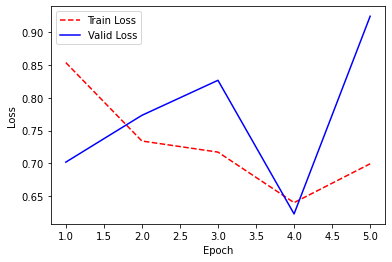

In [38]:
# Loss
plt.plot(epoch_count, train_loss, 'r--')
plt.plot(epoch_count, valid_loss, 'b-')
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

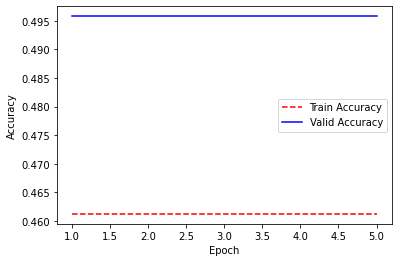

In [39]:
# Accuracy
plt.plot(epoch_count, train_acc, 'r--')
plt.plot(epoch_count, valid_acc, 'b-')
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Based on the plots, the model is no longer learning, and in fact is starting to over-fit on the training data.

### Load a set of 9 random images from the test_generator, run model.predict on them. and visualize the prediction scores along with the test images

In [40]:
test_result = model.predict(test_generator, steps=1)

In [41]:
test_result

array([[1.]], dtype=float32)

In [42]:
# Choose 9 random images
idx_list = np.random.choice(range(len(test_generator)),9,replace=False)
idx_list

array([97,  0, 18, 90, 58, 37, 23,  4, 71])

In [43]:
test_generator[101][1] # find the y_true

array([1], dtype=uint8)

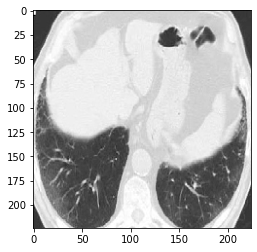

In [44]:
# find the image
plt.imshow(test_generator[101][0][0,:,:,0],cmap='gray')

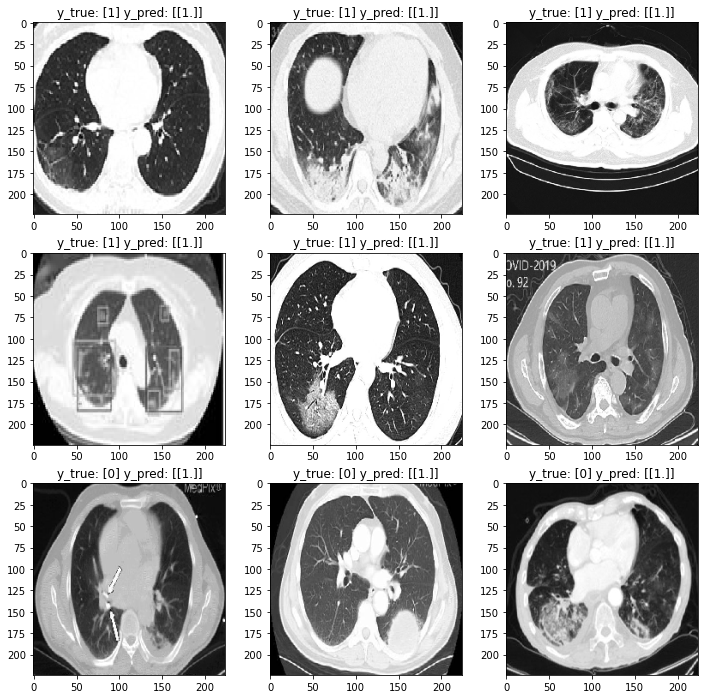

In [45]:
fig = plt.figure(figsize=(12,12))
axes = []
for i,idx in enumerate(idx_list):
    ax1 = fig.add_subplot(3,3,i+1)
    plt.imshow(test_generator[idx][0][0,:,:,0],cmap='gray')
    res = model.predict(test_generator[idx][0],1)
    plt.title(f"y_true: {test_generator[idx][1]} y_pred: {res}")

# Finish

In [46]:
finish_time = datetime.now()
print(f"Start time: {start_time}")
print(f"Finish time: {finish_time}")

Start time: 2021-06-01 07:42:58.200856
Finish time: 2021-06-01 08:02:12.664846
